In [16]:
import numpy
import sys
import pymzml
import scipy
import os
import math
import tensorly
import peakutils
import matplotlib
from scipy import signal
from matplotlib import pyplot
import glob
array3D=[]
raw_array=[]
raw_time=[]
import re

#define sort of samples in folder in numerical order
numbers = re.compile(r'(\d+)')
def numericalSort(value):
    parts = numbers.split(value)
    parts[1::2] = map(int, parts[1::2])
    return parts
labels=[]
for filename in sorted(glob.glob('D:/asp/extracts/Exp1 mzml/mixtures/*mzML'), key=numericalSort):    
    labels.append(filename.split('\\')[1][:-5]) #create a list with labels
    run = pymzml.run.Reader(filename)
    array=[]
    mass=[]
    time=[]
    for spectrum in run:
        time.append(round(spectrum.scan_time_in_minutes(),2))
        mass.append(spectrum.mz)
        peaks = spectrum.peaks("raw")[:,1]
        array.append(peaks)

        
    #reduce dimensionality by mass  
    aligned_mass=numpy.zeros(((len(time)),1300))
    for i in range (len(time)):   
        for j in range (len(mass[i])):
            int_mass=int(math.modf(mass[i][j])[1]) 
            if mass[i][j]<(int_mass+0.65):
                aligned_mass[i][int_mass]=aligned_mass[i][int_mass]+array[i][j]      
            else:
                if int_mass<1299:
                    aligned_mass[i][int_mass+1]=aligned_mass[i][int_mass+1]+array[i][j]
                else:
                    aligned_mass[i][int_mass]=aligned_mass[i][int_mass]+array[i][j]
    
    raw_array.append(aligned_mass)
    raw_time.append(time)
    
    data_mod=[]
    time_mod=[]
    for i in range (len(time)):
        if time[i]>1.98 and time[i]<21.98:
            time_mod.append(time[i])
            data_mod.append(aligned_mass[i])

    
     #denoising
    
    corr_noise=numpy.zeros((1300,len(time_mod)))
    raw_sim=numpy.zeros(len(time_mod))
    for j in range (100,1300):
        for i in range (len(time_mod)):
            raw_sim[i]=data_mod[i][j]
        sg_data=scipy.signal.savgol_filter (raw_sim,window_length=39,polyorder=9)
        base = peakutils.baseline(sg_data, deg=8, max_it=2, tol=1e-4)
        for i in range (len(time_mod)):
            if abs(sg_data[i])>base[i]*3:
                corr_noise[j][i]=raw_sim[i]
    aligned_time=numpy.arange(2.02,21.98,0.05)
    rescaled_time_array=numpy.zeros((400,1300))
    
    time_point=[]
    time_point.append([])
    n=0
    for i in range (1300):
        for j in range (len(time_mod)):
            if time_mod[j]<=aligned_time[n]:
                time_point[n].append(corr_noise[i][j])
            else:
                time_point.append([])
                time_point[n+1].append(corr_noise[i][j])
                n=n+1
        for k in range (len(aligned_time)):
            rescaled_time_array[k][i]=max(time_point[k])
        time_point=[]
        time_point.append([])
        n=0

    data_in_percent=numpy.zeros((360,1200))
    l=[]
    for j in range (100,1300):
        for i in range (360):
            l.append(rescaled_time_array[i][j])
        maxpeak=max(l)
        if maxpeak!=0:
            for c in range (360):
                data_in_percent[c][j-100]=(l[c]/maxpeak)*100
        l=[]
    array3D.append(data_in_percent)
    
from tensorly.decomposition import parafac
final_tensor=numpy.array(array3D)
weights, factors = parafac(final_tensor, rank=3,init='random',random_state=numpy.random.randint(0,1))
print (factors)
    

D:/asp/extracts/Exp1 mzml/mixtures\Exp1-001.mzML
D:/asp/extracts/Exp1 mzml/mixtures\Exp1-002.mzML
D:/asp/extracts/Exp1 mzml/mixtures\Exp1-003.mzML
D:/asp/extracts/Exp1 mzml/mixtures\Exp1-004.mzML
D:/asp/extracts/Exp1 mzml/mixtures\Exp1-005.mzML
D:/asp/extracts/Exp1 mzml/mixtures\Exp1-006.mzML
D:/asp/extracts/Exp1 mzml/mixtures\Exp1-007.mzML
D:/asp/extracts/Exp1 mzml/mixtures\Exp1-008.mzML
D:/asp/extracts/Exp1 mzml/mixtures\Exp1-011.mzML
D:/asp/extracts/Exp1 mzml/mixtures\Exp1-012.mzML
D:/asp/extracts/Exp1 mzml/mixtures\Exp1-013.mzML
D:/asp/extracts/Exp1 mzml/mixtures\Exp1-014.mzML
D:/asp/extracts/Exp1 mzml/mixtures\Exp1-015.mzML
D:/asp/extracts/Exp1 mzml/mixtures\Exp1-016.mzML
D:/asp/extracts/Exp1 mzml/mixtures\Exp1-019.mzML
D:/asp/extracts/Exp1 mzml/mixtures\Exp1-020.mzML
D:/asp/extracts/Exp1 mzml/mixtures\Exp1-021.mzML
D:/asp/extracts/Exp1 mzml/mixtures\Exp1-022.mzML
D:/asp/extracts/Exp1 mzml/mixtures\Exp1-031.mzML
D:/asp/extracts/Exp1 mzml/mixtures\Exp1-032.mzML
D:/asp/extracts/Exp1

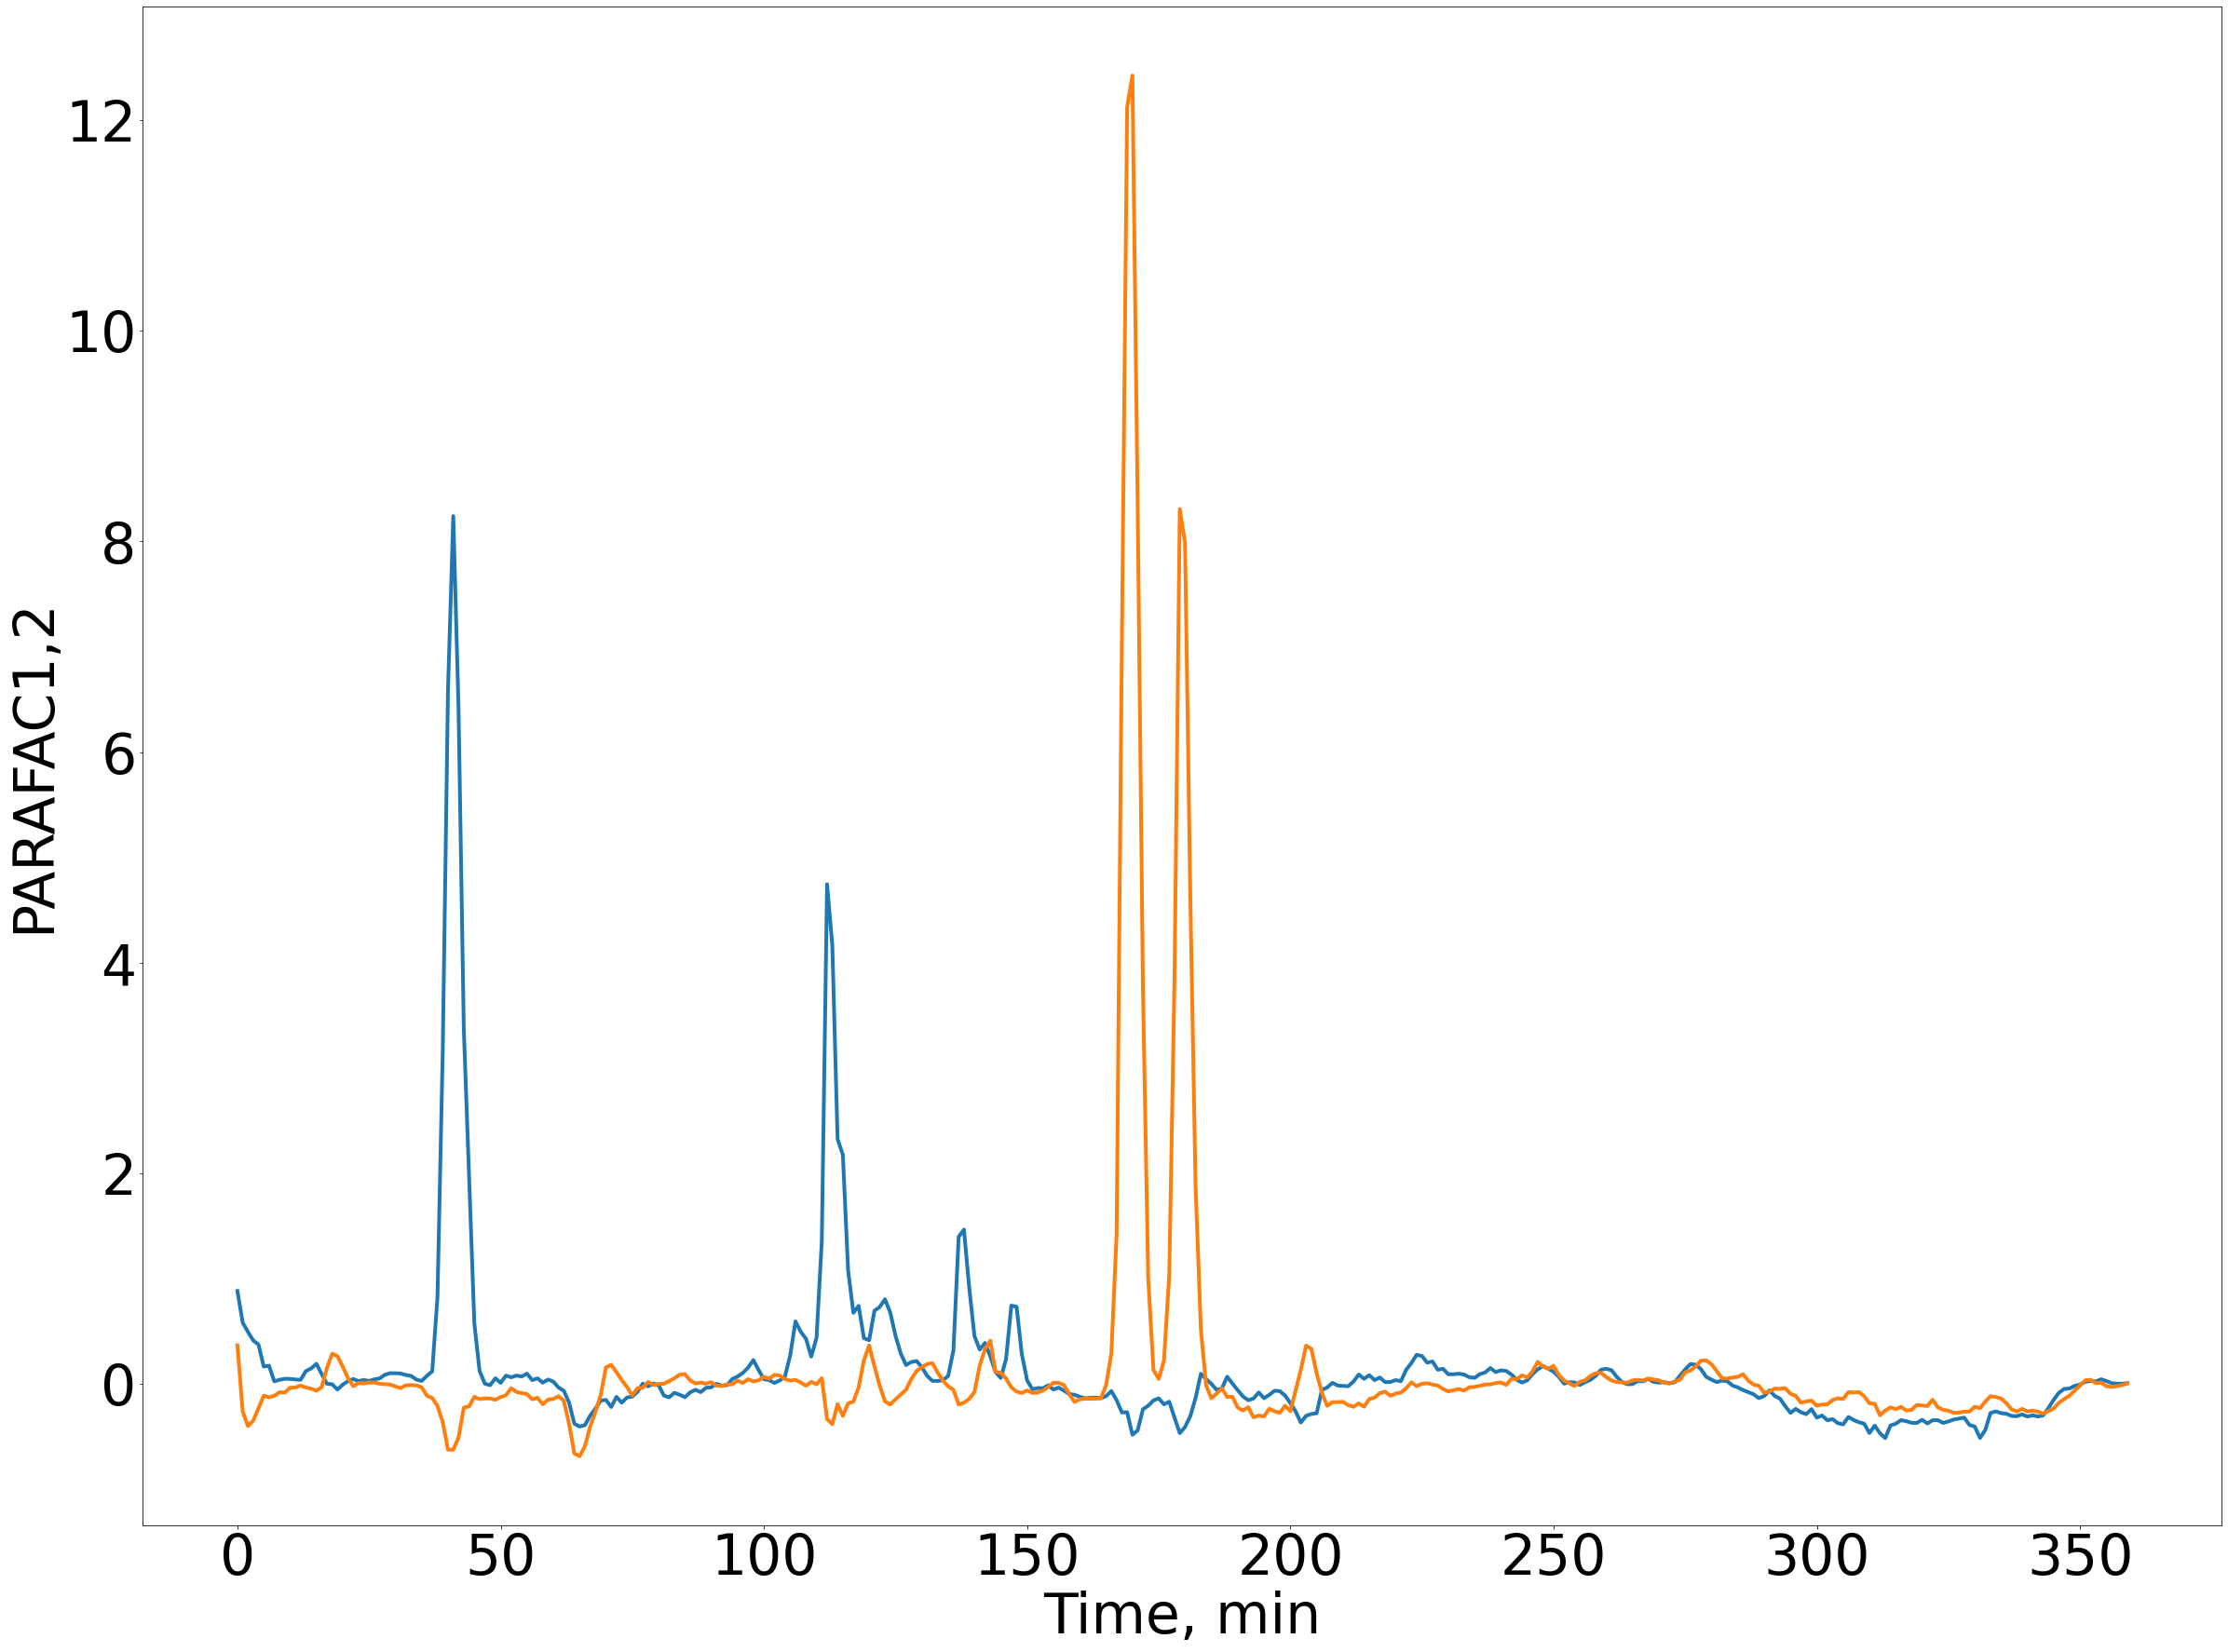

In [24]:
fig, ax = pyplot.subplots(figsize=(40,30))
pyplot.plot(factors[1][:,0],linewidth=4)
pyplot.plot(factors[1][:,2],linewidth=4)
pyplot.xlabel("Time, min",size=60)
pyplot.ylabel("PARAFAC1,2",size=60)
ax.tick_params(color="black",labelsize=60,colors="black",grid_color="black")

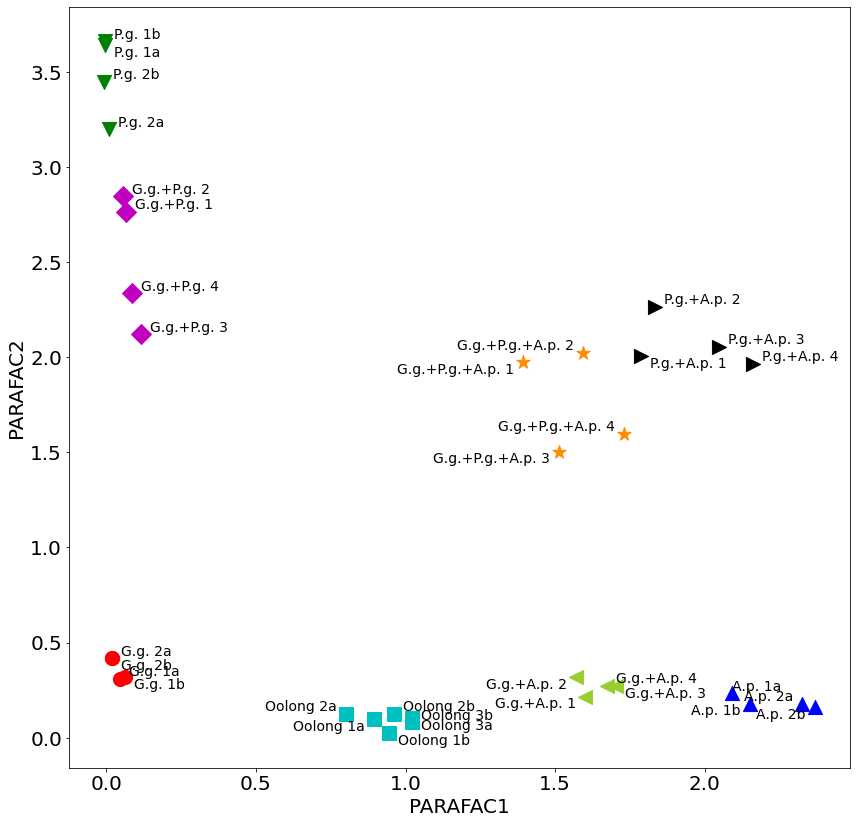

In [25]:
from matplotlib import pyplot
z=numpy.zeros(len(factors[0]))
y=numpy.zeros(len(factors[0]))              
n=["  G.g. 1a","  G.g. 1b","  G.g. 2a","  G.g. 2b","  P.g. 1a","  P.g. 1b","  P.g. 2a","  P.g. 2b","A.p. 1a  ","A.p. 1b  ","A.p. 2a  ","A.p. 2b  ","Oolong 1a  ","  Oolong 1b","Oolong 2a  ","  Oolong 2b","  Oolong 3a","  Oolong 3b","  G.g.+P.g. 1","  G.g.+P.g. 2","  G.g.+P.g. 3","  G.g.+P.g. 4","G.g.+A.p. 1  ","G.g.+A.p. 2  ","  G.g.+A.p. 3","  G.g.+A.p. 4","  P.g.+A.p. 1","  P.g.+A.p. 2","  P.g.+A.p. 3","  P.g.+A.p. 4","G.g.+P.g.+A.p. 1  ","G.g.+P.g.+A.p. 2  ","G.g.+P.g.+A.p. 3  ","G.g.+P.g.+A.p. 4  "]
for i in range (len(factors[0])):
    z[i]=factors[0][i][2]
    y[i]=factors[0][i][0]

categories = numpy.array([0, 0, 0,0, 1, 1, 1, 1, 2, 2, 2, 2,3,3,3,3,3,3,4,4,4,4,5,5,5,5,6,6,6,6,7,7,7,7])
colormap = numpy.array(['r', 'r','r','r','g', 'g','g','g','b','b','b','b','c','c','c','c','c','c','m','m','m','m','yellowgreen','yellowgreen','yellowgreen','yellowgreen','k','k','k','k','darkorange','darkorange','darkorange','darkorange'])
fig, ax = pyplot.subplots(figsize=(14,14))
markers=['o', 'o', 'o', 'o', 'v', 'v', 'v', 'v', '^', '^', '^', '^', 's', 's', 's', 's', 's', 's', 'D', 'D', 'D', 'D', '<', '<', '<', '<', '>', '>', '>', '>', '*', '*', '*', '*']
for i in range (34):    
    ax.scatter(z[i],y[i],s=200,c=colormap[i],marker=markers[i])
pyplot.xlabel("PARAFAC1",size=20)
pyplot.ylabel("PARAFAC2",size=20)
ax.tick_params(labelsize=20)
s=[1,3,4,13,16,24,26]
t=[9,11,12,22,23,30,32]
k=[10,14,31,33]
l=[0,2,5,6,7,8,15,17,18,19,20,21,25,27,28,29]
for i, txt in enumerate(n):
    if i in s:
        ax.annotate(txt, (z[i], y[i]),size=14,horizontalalignment='left', verticalalignment='top')
    if i in t:
        ax.annotate(txt, (z[i], y[i]),size=14,horizontalalignment='right', verticalalignment='top')
    if i in k:
        ax.annotate(txt, (z[i], y[i]),size=14,horizontalalignment='right', verticalalignment='bottom')
    if i in l:
        ax.annotate(txt, (z[i], y[i]),size=14,horizontalalignment='left', verticalalignment='bottom')